# Handwritten Digit Classifier Project
In this project a handwritten digit classifier will be constructed by using a neural network. The `load_digits` dataset from `sklearn.datasets` will be used to train and test the neural network. To be able to identify the digits, image recognition has to be used. 

But image recognition is a difficult task:

* each pixel is a feature (large amount of data)
* no clear linear or non-linear correlation between pixels -> mostly deep neural networks are useful
* neural networks require large datasets to train and are computationally expensive to train

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
import time

Get Dataset

In [2]:
digits_raw = load_digits()

In [3]:
digits_raw.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

Turning the `data` column into a DataFrame

In [4]:
digits_data = pd.DataFrame(digits_raw.data)
digits_data.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


Each row has 64 values --> each image is represented by a 8x8 picture.
Visualizing some of the digits:

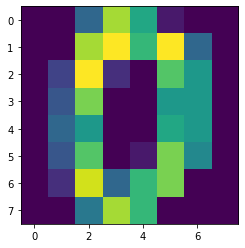

In [5]:
plt.imshow(digits_data.iloc[0].values.reshape(8,8))

Now visualizing multiple images in black and white. Using grayscale instead of color can help focus the training of the neural network on recognizing shapes instead of looking for patterns in the color. It makes the images much less complicated. This is especially useful in applications such as this, where the color is not a useful feature at all.

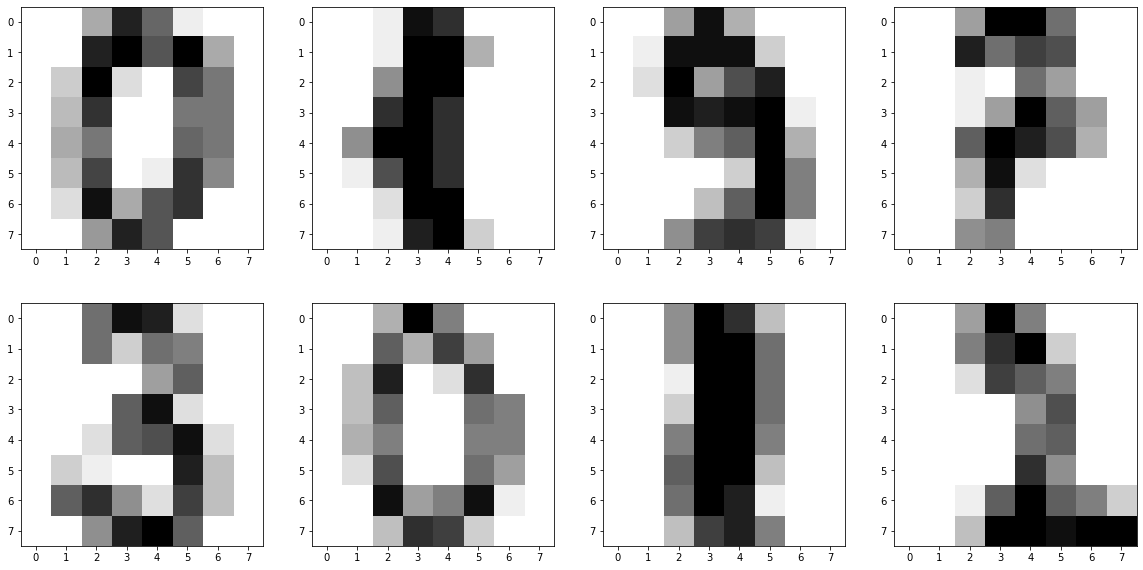

In [7]:
fig, axs = plt.subplots(2,4, figsize = (20,10))
axs[0,0].imshow(digits_data.iloc[0].values.reshape(8,8), cmap = 'gray_r')
axs[0,1].imshow(digits_data.iloc[99].values.reshape(8,8), cmap = 'gray_r')
axs[0,2].imshow(digits_data.iloc[199].values.reshape(8,8), cmap = 'gray_r')
axs[0,3].imshow(digits_data.iloc[299].values.reshape(8,8), cmap = 'gray_r')
axs[1,0].imshow(digits_data.iloc[999].values.reshape(8,8), cmap = 'gray_r')
axs[1,1].imshow(digits_data.iloc[1099].values.reshape(8,8), cmap = 'gray_r')
axs[1,2].imshow(digits_data.iloc[1199].values.reshape(8,8), cmap = 'gray_r')
axs[1,3].imshow(digits_data.iloc[1299].values.reshape(8,8), cmap = 'gray_r')

## Dividing Dataset Into Train and Test Sets:

* shuffle the DS
* reindex
* 80% are training
* 20% are test

In [8]:
features = digits_data
target = pd.Series(digits_raw.target)

In [9]:
np.random.seed(1)
new_ind = np.random.permutation(target.index)
features_shuff = features.copy().reindex(index = new_ind).reset_index().drop(columns = 'index')
target_shuff = target.copy().reindex(index = new_ind).reset_index().drop(columns = 'index')
cut_ind = int(len(target_shuff)*0.8)
train_feats = features_shuff.iloc[:cut_ind]
train_targs = target_shuff.iloc[:cut_ind]
test_feats = features_shuff.iloc[cut_ind:]
test_targs = target_shuff.iloc[cut_ind:]

## First Machine Learning Algorithm: K-Nearest Neighbors

Advantages:

* no presumptions about possible linearity between features and targets
* no actual training process

Disadvantages:

* typically very limited in accuracy
* Has to look through entire (part of dataset) for each value --> quickly becomes very expensive on large datasets

In [10]:
train_targs.values

array([[1],
       [5],
       [0],
       ...,
       [7],
       [6],
       [3]])

In [11]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(train_feats.values, np.ravel(train_targs.values,order = 'C'))
predictions_knn = knn.predict(test_feats)
accuracy_score(test_targs, predictions_knn)

0.9833333333333333

The algorithm is very good at chosing the right digit

Cross validation instead of simple 80/20 split of DF:

In [14]:
from sklearn.model_selection import KFold, cross_val_score
def train_and_test_knn(k):
    '''Train and test a k-nearest neighbors model on the dataset
    Args:
        k(int): k-value of nearest neighbors to find
    Returns:
        float: accuracy score of the model
    '''
    kf = KFold(4, shuffle = True, random_state = 2)
    model = KNeighborsClassifier(n_neighbors = k, n_jobs = 4)
    accs = cross_val_score(model, features, target, scoring = 'accuracy', cv = kf,
                           n_jobs = 4)
    return accs.mean()

In [15]:
train_and_test_knn(5)

0.9849777282850779

This model performs much better than expected even when using cross validation to calculate the accuracy metric

Impact of the k-value on accuracy and computation time

In [21]:
ks = []
accs = []
times = []

for k in range(1,15):
    t0 = time.time()
    ks.append(k)
    accs.append(train_and_test_knn(k))
    times.append(time.time() - t0)

In [22]:
results = pd.DataFrame([ks,accs,times])
results = results.transpose()
results.columns = ['k', 'accuracy', 'time']
results

,k,accuracy,time
0,1.0,0.988873,0.157143
1,2.0,0.982191,0.157143
2,3.0,0.987201,0.139127
3,4.0,0.983307,0.157142
4,5.0,0.984978,0.157143
5,6.0,0.982752,0.159145
6,7.0,0.984422,0.158144
7,8.0,0.980527,0.138125
8,9.0,0.982757,0.167657
9,10.0,0.978859,0.159145


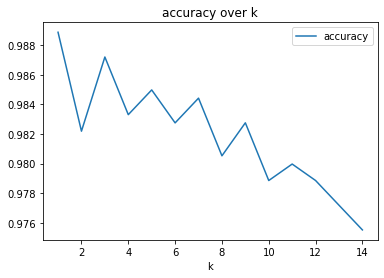

In [23]:
results.plot.line(x = 'k', y = 'accuracy')
plt.title('accuracy over k')
plt.show()

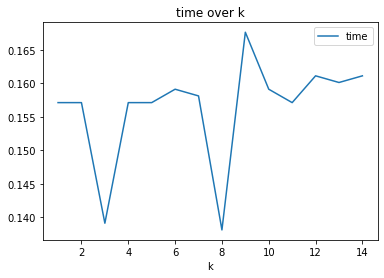

In [25]:
results.plot.line(x = 'k', y = 'time')
plt.title('time over k')
plt.show()

The accuracy of the model decreases with higher k-values, but it is not strongly impacted at all. The lowest measured accuracy is at 97.6% when using a k-value of 14. While the lower k-values show a slightly higher accuracy, they are also more susceptible to falsely identified single nearest neighbors, to alleviate this problem, it might be advantageous to use a k-value of about 5. In general the uneven k-values are more accurate than the closest even k-values. This could be caused by the fact, that even k-values can lead to a tie when half of the nearest neighbors are identified as one value and the other half is identified as a different value. Uneven numbers can break the tie and due to the high correct identification percentage, the additional neighbor is likely to be identified correctly, reducing the error metric. Using a slightly higher k-value will also not impact the performance, as can be seen in the second graph.

## Neural Network:

Neural network will be constructed for the same problem. Starting off with only one hidden layer. The number of neurons will be increased first to understand how this impacts performance. Later more hidden layers will be added.

In [28]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, cross_val_score
def train_and_test_nn(hl):
    '''Train and test a neural network to identify the handwritten digits in the dataset
    Args:
        hl (int, int(optional), ...): number of neurons in hidden layers
    Returns:
        float: accuracy metric of the model
    '''
    kf = KFold(n_splits = 5, shuffle = True, random_state = 2)
    model = MLPClassifier(hidden_layer_sizes = hl, activation = 'tanh', shuffle = False)
    accs = cross_val_score(model, features, target, scoring = 'accuracy', cv = kf, n_jobs = -1)
    return accs.mean()

In [27]:
train_and_test_nn(8,)

0.8987356855462704

Even with only one hidden layer and 8 neurons, the model already reaches an accuracy metric of 0.90.

Impact of the number of neurons in the first layer on the computational expense and accuracy:

In [29]:
import time
ks = []
accs = []
times = []
for k in [3,4,5,6,7,8]:
    t0 = time.time()
    ks.append(2**k)
    accs.append(train_and_test_nn((2**k,)))
    ti = time.time() - t0
    times.append(ti)
    print(ti)    

1.0629663467407227
1.061964511871338
0.8407642841339111
1.1150133609771729
1.311192512512207
1.738579273223877


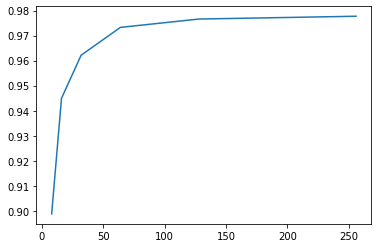

In [36]:
plt.plot(ks,accs)

At higher neuron counts the improvement in accuracy hits a point of diminishing returns. The problem becomes slightly more computationally expensive. The accuracy with 256 neurons is at around 98 %. Now a neural network with two hidden layers:

In [30]:
print(train_and_test_nn((64,64)))

0.9660646858557722


A neural network with two hidden layers of 64 neurons performs comparably to the k-nearest-neighbors model

## Neural Network with Three Hidden Layers
Now looking at a model with three hidden layers. This can lead to overfitting, so the number of folds will be increased to 6.

In [35]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, cross_val_score
def train_and_test_nn(hl):
    '''Train and test a neural network to identify the handwritten digits in the dataset
    Args:
        hl (int, int(optional), ...): number of neurons in hidden layers
    Returns:
        float: accuracy metric of the model
    '''    
    t0 = time.time()
    kf = KFold(n_splits = 6, shuffle = True, random_state = 2)
    model = MLPClassifier(hidden_layer_sizes = hl, activation = 'tanh', shuffle = False)
    accs = cross_val_score(model, features, target, scoring = 'accuracy', cv = kf, n_jobs = -1)
    print(time.time() - t0)
    return accs.mean()

In [36]:
accs = []
ks = []
for k in [10,64,128]:
    accs.append(train_and_test_nn((k,k,k)))
    ks.append(k)

1.058962345123291
1.3822557926177979
2.155463218688965


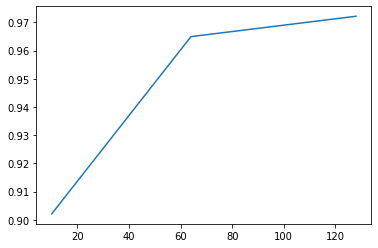

In [37]:
plt.plot(ks,accs)

# Results
With the larger amount of neurons in the hidden layers, the accuracy of the model can be increased slightly. Using three hidden layers with 128 neurons each, the neural network reached an accuracy of 97%. This is comparable to the k-nearest neighbors model. The computation for this model took about 15 times as long as the computation of the k-nearest neighbors model.

The computational advantage of the k-nearest neighbors model disappears very quickly, though. The most expensive part of the neural network by far is the training process and this only has to be completed once. Once a neural network is trained, it can make predictions while using much less resources. The k-neighbors model however still has to compare every new value that needs to be classified to every single value in the training set. When using a model to make a lot of predictions, this can quickly add up.

In addition the k-neighbors classifier does not scale well on larger datasets. As the number of values in the dataset increase, the k-neighbors model still has to compare each new value to every one of the values in the training set. This quickly becomes prohibitively expensive.

These factors make the neural network suited to repeated use and use on larger datasets. But while classifying small datasets for only a limited number of uses, the k-neighbors classifier can be a computationally cheap and very simple alternative.

# Summary

In this project, two machine learning models were constructed to classify a dataset of handwritten digits:

* k-neighbors classifier: this model is very simple and computationally inexpensive when applied s limited amount of times to a small dataset. It showed an accuracy of up to 99%. 

* neural network: this model showed an accuracy of up to 97% when using three hidden layers with 128 neurons each. It is best suited to larger datasets and is much more versatile than the k-neighbors model. Optimizing the number of hidden layers and neurons as well the neural network model itself (for example using different activation functions) could increase the accuracy further.